In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from tensorflow import keras
import itertools
from timeit import default_timer as timer
from keras.callbacks import EarlyStopping

In [2]:
#import training set
train_df = pd.read_csv('./air_pollution_train.csv')

#import test data
test_dataset=pd.read_csv('./air_pollution_test.csv')
y_test=test_dataset.iloc[:,1:2]

#Convert df fo a nmupy array
train_set = train_df.iloc[:,1:2].values

#Apply minmax scaler since we have sigmoid AF
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_set)




In [9]:


# Create a function for generating  time series data with any time steps we want
def data_generator(time_steps):
    X_train=[]
    y_train=[]
    X_test=[]
    for i in range(time_steps, len(train_set)):
        X_train.append(scaled_train_set[i-time_steps:i, 0])
        y_train.append(scaled_train_set[i, 0])

#convert X_train and y_train to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    #merge test and train and get the value we need for prediction
    whole_dataset = pd.concat((train_df['AQI'],test_dataset['AQI']), axis=0)
    inputs = whole_dataset[len(whole_dataset)-len(test_dataset)-time_steps:].values
    inputs = inputs.reshape(-1,1)

    # Scale inputs
    inputs = scaler.transform(inputs)

    for i in range(time_steps, len(test_dataset)+time_steps):
        X_test.append(inputs[i-time_steps:i, 0])
    #convert X_test to numpy array
    X_test = np.array(X_test)


    #Add new dimention to create a tensor
    X_train = np.reshape(X_train, (len(X_train),time_steps,1))
    X_test = np.reshape(X_test, (len(X_test),time_steps,1))

    return X_train, y_train, X_test

#Grid search params
units = [5,25,50]
n_timesteps = [5, 30, 80]
activation_number= [1,2,3]



hyper_params = ( units, n_timesteps,activation_number)
hyper_params_grid = tuple(itertools.product(*hyper_params, repeat=1))

train_loss_grid, val_loss_grid = list(), list()
best_params_RNN = []
best_params_LSTM = []
best_params_GRU = []


def fit_RNN_grid_search(batch_size):
  min_val_loss = 999
  current_val_loss = 0
  for units, n_timesteps, activation_number in hyper_params_grid:
    if activation_number == 1:
      activations='relu'
    elif activation_number == 2:
      activations='sigmoid'
    elif activation_number == 3:
      activations='softmax'
    print('RNN model units: ', units, 'n_timesteps: ', n_timesteps, 'activation: ',activations)
    # Define an early stopping callback to prevent from meaningless epochs
    earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=4)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(units = units, activation=activations, return_sequences = True, input_shape=(n_timesteps, 1)))
    RNN_model.add(Dropout(0.2))
    RNN_model.add(SimpleRNN(units = units,activation=activations))
    RNN_model.add(Dropout(0.2))
    RNN_model.add(Dense(units=1))
    RNN_model.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])
    # fit model
    X_train, y_train, X_test = data_generator(n_timesteps)
    RNN_model_regressor = RNN_model.fit(X_train,y_train,epochs=50,batch_size=batch_size, validation_split=0.2,callbacks=[earlyStop])
    current_val_loss = RNN_model_regressor.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params_RNN = [units,n_timesteps,activations]
      print('best_params',best_params_RNN)
  return best_params_RNN

def fit_LSTM_grid_search(batch_size):
  min_val_loss = 999
  current_val_loss = 0
  for units, n_timesteps, activation_number in hyper_params_grid:
    if activation_number == 1:
      activations='relu'
    elif activation_number == 2:
      activations='sigmoid'
    elif activation_number == 3:
      activations='softmax'
    print('LSTM model units: ', units, 'n_timesteps: ', n_timesteps, 'activation: ',activations)
    # Define an early stopping callback to prevent from meaningless epochs
    earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=4)
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(units = units, return_sequences = True, activation=activations, input_shape=(n_timesteps, 1)))
    LSTM_model.add(Dropout(0.2))
    LSTM_model.add(LSTM(units = units, activation=activations))
    LSTM_model.add(Dropout(0.2))
    LSTM_model.add(Dense(units=1))
    LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    # fit model
    X_train, y_train, X_test = data_generator(n_timesteps)
    LSTM_model_regressor = LSTM_model.fit(X_train,y_train,epochs=50,batch_size=batch_size, validation_split=0.2,callbacks=[earlyStop])
    current_val_loss = LSTM_model_regressor.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params_LSTM = [units,n_timesteps,activations]
      print('best_params',best_params_LSTM)
  return best_params_LSTM

def fit_GRU_grid_search(batch_size):
  min_val_loss = 999
  current_val_loss = 0
  for units, n_timesteps, activation_number in hyper_params_grid:
    if activation_number == 1:
      activations='relu'
    elif activation_number == 2:
      activations='sigmoid'
    elif activation_number == 3:
      activations='softmax'
    print('GRU Model units: ', units, 'n_timesteps: ', n_timesteps, 'activation: ',activations)
    # Define an early stopping callback to prevent from meaningless epochs
    earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=4)
    GRU_model = Sequential()
    GRU_model.add(GRU(units = units, return_sequences = True, activation=activations, input_shape=(n_timesteps, 1)))
    GRU_model.add(Dropout(0.2))
    GRU_model.add(GRU(units = units,activation=activations))
    GRU_model.add(Dropout(0.2))
    GRU_model.add(Dense(units=1))
    GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    # fit model
    X_train, y_train, X_test = data_generator(n_timesteps)
    GRU_model_regressor = GRU_model.fit(X_train,y_train,epochs=50,batch_size=batch_size, validation_split=0.2, callbacks=[earlyStop])
    current_val_loss = GRU_model_regressor.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params_GRU = [units,n_timesteps,activations]
      print('best_params',best_params_GRU)
  return best_params_GRU

def run_grid():
  n_batch = 32
  best_params_RNN = fit_RNN_grid_search(n_batch)
  best_params_LSTM = fit_LSTM_grid_search(n_batch)
  best_params_GRU = fit_GRU_grid_search(n_batch)
  return best_params_RNN,best_params_LSTM,best_params_GRU


In [10]:
start = timer()
best_params_RNN, best_params_LSTM, best_params_GRU = run_grid()
end=timer()
print("Time Taken -> ",str(end-start))
print("Best params of RNN model are: ",best_params_RNN,
      "Best params of LSTM model are: ",best_params_LSTM,
      "Best params of GRU model are: ",best_params_GRU)

RNN model units:  5 n_timesteps:  5 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1037 - mse: 0.1037 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 6: early stopping
RNN model units:  5 n_timesteps:  30 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 24.0440 - mse: 24.0440 - val_loss: 1.8822 - val_mse: 1.8822
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8433 - mse: 0.8433 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0085 - mse: 0.0085 -

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2663 - mse: 0.2663 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1459 - mse: 0.1459 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0234 - mse: 0.0234 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0876 - mse: 0.0876 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - mse: 0.0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.7166 - mse: 0.7166 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0039 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0066 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0056 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2059 - mse: 0.2059 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mse: 0.0083 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mse: 0.0049 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - mse: 0.0026 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0940 - mse: 0.0940 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5: early stopping
RNN model units:  25 n_timesteps:  30 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1163 - mse: 0.1163 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5: early stopping
RNN model units:  25 n_timesteps:  80 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0046 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6: early stopping
RNN model units:  50 n_timesteps:  5 activation:  sigmoid
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0946 - mse: 0.0946 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mse: 0.0051 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mse: 0.0045 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5: early stopping
RNN model units:  50 n_timesteps:  30 activation:  sigmoid
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3465 - mse: 0.3465 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8: early stopping
RNN model units:  50 n_timesteps:  30 activation:  softma

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7: early stopping
RNN model units:  50 n_timesteps:  80 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0024 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1726 - mse: 0.1726 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5: early stopping
RNN model units:  50 n_timesteps:  80 activation:  softmax


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6: early stopping
LSTM model units:  5 n_timesteps:  5 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - mse: 0.0036 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2332 - mse: 0.2332 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - mse: 0.0122 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mse: 0.0052 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5: early stopping
LSTM model units:  5 n_timesteps:  30 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1139 - mse: 0.1139 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0062 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0038 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0072 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0612 - mse: 0.0612 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0043 - mse: 0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - mse: 0.0031 - va

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5: early stopping
LSTM model units:  25 n_timesteps:  5 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - mse: 0.0043 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0031 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0063 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0041 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0033 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0523 - mse: 0.0523 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 5: early stopping
LSTM model units:  25 n_timesteps:  80 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0044 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - mse: 0.0029 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0544 - mse: 0.0544 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - mse: 0.0046 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mse: 0.0042 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0034 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1377 - mse: 0.1377 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0055 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0046 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0034 - mse: 0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.1703 - mse: 0.1703 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6: early stopping
LSTM model units:  50 n_timesteps:  80 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0041 - mse: 0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8: early stopping
best_params [5, 5, 'relu']
GRU Model units:  5 n_timesteps

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0740 - mse: 0.0740 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - mse: 0.0055 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7: early stopping
GRU Model units:  5 n_timesteps:  30 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0034 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5197 - mse: 0.5197 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1887 - mse: 0.1887 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1277 - mse: 0.1277 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1062 - mse: 0.1062 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0305 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0045 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0033 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.5312 - mse: 0.5312 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1442 - mse: 0.1442 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1024 - mse: 0.1024 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7: early stopping
GRU Model units:  5 n_timesteps:  80 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0048 - mse: 0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - mse: 0.0029 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0910 - mse: 0.0910 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7: early stopping
GRU Model units:  25 n_timesteps:  5 activation:  softmax


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - mse:

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0027 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5: early stopping
GRU Model units:  25 n_timesteps:  30 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6: early stopping
GRU Model units:  25 n_timesteps:  80 activation:  relu
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0030 - mse:

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0902 - mse: 0.0902 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7: early stopping
GRU Model units:  25 n_timesteps:  80 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8: early stopping
GRU Model units:  50 n_timesteps:  5 activation:

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - mse: 0.0024 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6: early stopping
GRU Model units:  50 n_timesteps:  5 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mse: 0.0043 - v

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0026 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.5755 - mse: 0.5755 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0843 - mse: 0.0843 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0386 - mse: 0.0386 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7: early stopping
GRU Model units:  50 n_timesteps:  30 activation:  softmax
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0045 - mse: 0.

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0025 - mse: 0

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.3917 - mse: 0.3917 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0927 - mse: 0.0927 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0087 - mse:

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6: early stopping
Time Taken ->  2583.3129817999998
Best params of RNN model are:  [25, 80, 'relu'] Best params of LSTM model are:  [50, 80, 'relu'] Best params of GRU model are:  [25, 5, 'relu']


longest time step is: 80


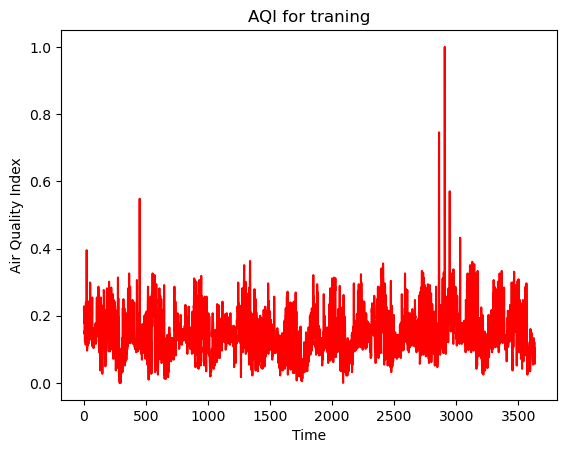

In [20]:
print("longest time step is:", max(best_params_RNN[1],best_params_LSTM[1],best_params_GRU[1]))
time_steps = max(best_params_RNN[1],best_params_LSTM[1],best_params_GRU[1])

X_train, y_train, X_test = data_generator(time_steps)

#plot the traning dataset
plt.plot(y_train, color= 'red', label= 'AQI')
plt.title('AQI for traning')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.show()


In [11]:

# train model with best of thier units and longest time step
#MLP model
MLP_regressor = Sequential()
MLP_regressor.add(Dense(50, activation='relu', input_dim=time_steps))
MLP_regressor.add(Dense(1))
MLP_regressor.compile(optimizer='adam', loss='mse')
MLP_model = MLP_regressor.fit(X_train, y_train, epochs = 50, batch_size= 32)

# Making the predictions
predicted_values_MLP = MLP_regressor.predict(X_test)

# Inverse the scaling
predicted_values_MLP = scaler.inverse_transform(predicted_values_MLP)

# Build RNN model
RNN_regressor = Sequential()
RNN_regressor.add(SimpleRNN(units = best_params_RNN[0], return_sequences = True, input_shape=(time_steps, 1)))

#add dropout to prevnt overfitting
RNN_regressor.add(Dropout(0.2))

#second layer
RNN_regressor.add(SimpleRNN(units = best_params_RNN[0],activation=best_params_RNN[2]))
RNN_regressor.add(Dropout(0.2))

#output layer
RNN_regressor.add(Dense(units=1))

#compile the model
RNN_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

#fit the model
RNN_model = RNN_regressor.fit(X_train, y_train, epochs = 50, batch_size= 32)

# Making the predictions
predicted_values_RNN = RNN_regressor.predict(X_test)

# Inverse the scaling
predicted_values_RNN = scaler.inverse_transform(predicted_values_RNN)

# Build LSTM model
LSTM_regressor = Sequential()
LSTM_regressor.add(LSTM(units = best_params_LSTM[0],activation=best_params_LSTM[2], return_sequences = True, input_shape=(time_steps, 1)))

#add dropout to prevnt overfitting
LSTM_regressor.add(Dropout(0.2))

#second layer
LSTM_regressor.add(LSTM(units = best_params_LSTM[0],  activation=best_params_LSTM[2]))
LSTM_regressor.add(Dropout(0.2))

#output layer
LSTM_regressor.add(Dense(units=1))

#compile the model
LSTM_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

#fit the model
LSTM_model = LSTM_regressor.fit(X_train, y_train, epochs = 50, batch_size= 32)

# Making the predictions
predicted_values_LSTM = LSTM_regressor.predict(X_test)

# Inverse the scaling
predicted_values_LSTM = scaler.inverse_transform(predicted_values_LSTM)

# Build GRU model
GRU_regressor = Sequential()
GRU_regressor.add(GRU(units = best_params_GRU[0], return_sequences = True,activation=best_params_GRU[2], input_shape=(time_steps, 1)))

#add dropout to prevnt overfitting
GRU_regressor.add(Dropout(0.2))

#second layer
GRU_regressor.add(GRU(units = best_params_GRU[0], activation=best_params_GRU[2]))
GRU_regressor.add(Dropout(0.2))

#output layer
GRU_regressor.add(Dense(units=1))

#compile the model
GRU_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

#fit the model
GRU_model = GRU_regressor.fit(X_train, y_train, epochs = 50, batch_size= 32)

# Making the predictions
predicted_values_GRU = GRU_regressor.predict(X_test)

# Inverse the scaling
predicted_values_GRU = scaler.inverse_transform(predicted_values_GRU)




longest time step is: 80
Epoch 1/50


C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0390  
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0033
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0032
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0025
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0025
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0031
Epoch 13/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0024
Epoch 14/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 15/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0097 - mse: 0.0097
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0041 - mse: 0.0041
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0036 - mse: 0.0036
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0033 - mse: 0.0033
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0031 - mse: 0.0031
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032 - mse: 0.0032
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0029 - mse: 0.0029
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028 - mse: 0.0028
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0027 - mse: 0.0027
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0031 - mse: 0.0031
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026 - mse: 0.0026
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0029 - mse: 0.0029
Epoch 13/50
114/114 ━━━━

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0102 - mse: 0.0102
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0040 - mse: 0.0040
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0038 - mse: 0.0038
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0034 - mse: 0.0034
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0036 - mse: 0.0036
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0041 - mse: 0.0041
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0038 - mse: 0.0038
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0036 - mse: 0.0036
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0033 - mse: 0.0033
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0034 - mse: 0.0034
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0041 - mse: 0.0041
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0033 - mse: 0.0033
Epoch 13/50
114/114 ━━━━

C:\Users\29515\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0094 - mse: 0.0094
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0041 - mse: 0.0041
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0039 - mse: 0.0039
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 0.0036 - mse: 0.0036
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0032 - mse: 0.0032
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0029 - mse: 0.0029
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0032 - mse: 0.0032
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0029 - mse: 0.0029
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0029 - mse: 0.0029
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0027 - mse: 0.0027
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0030 - mse: 0.0030
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0030 - mse: 0.0030
Epoch 13/50
114/114 ━

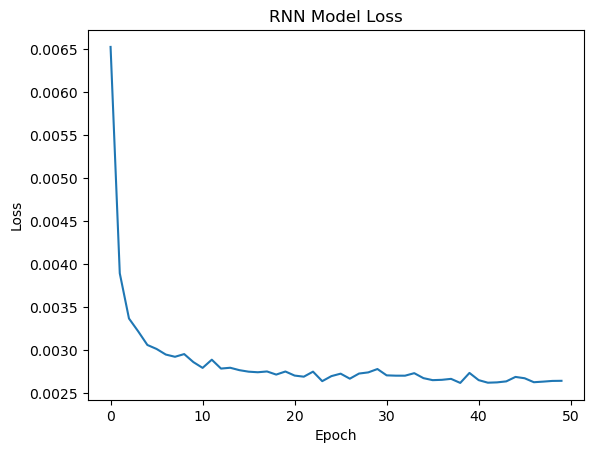

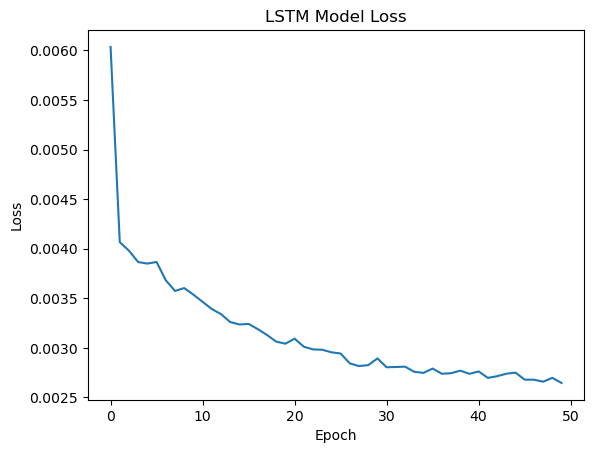

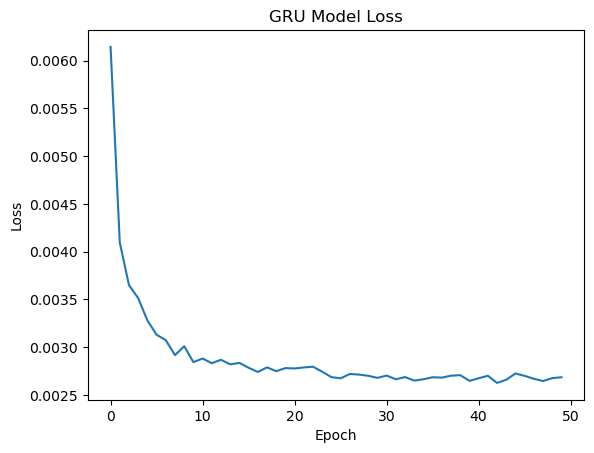

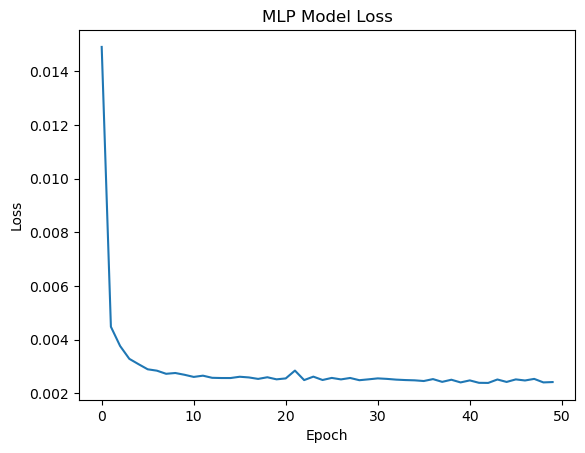

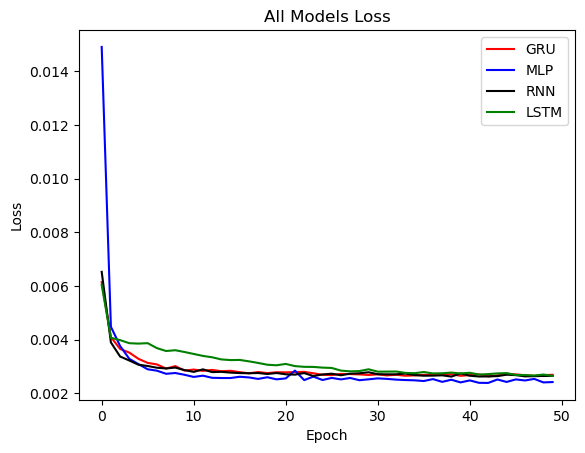

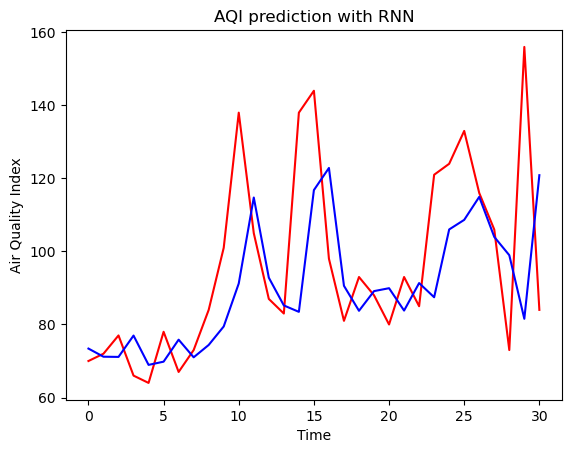

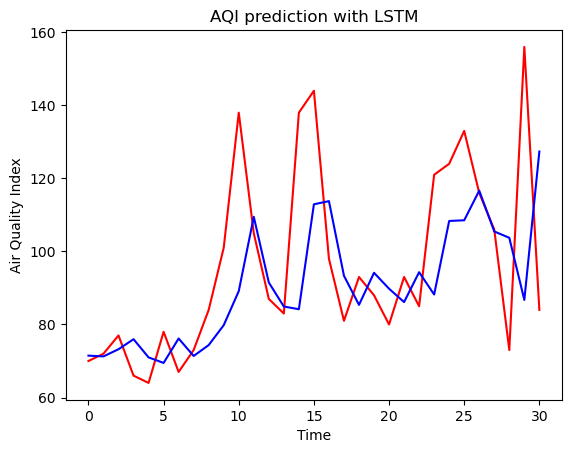

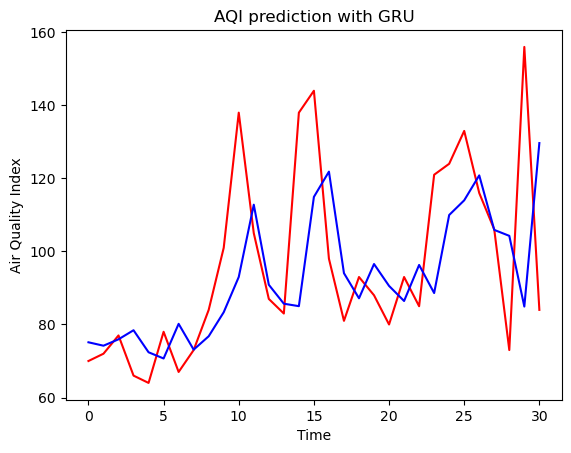

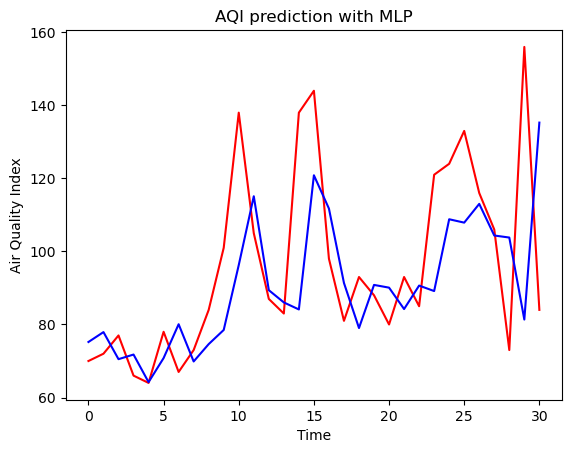

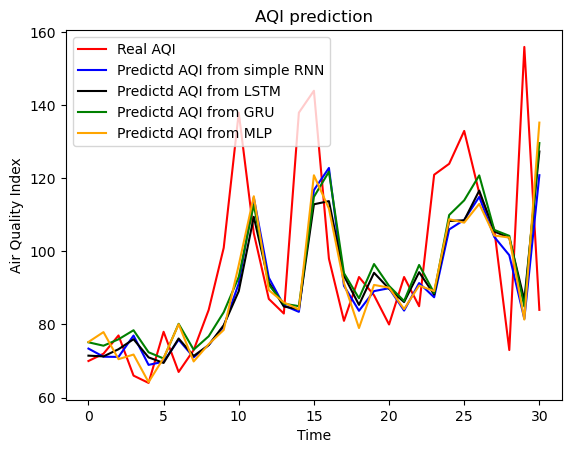

In [19]:
# Visualisig

# Plot loss per epoch for RNN
plt.plot(RNN_model.history['mse'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot loss per epoch for LSTM
plt.plot(LSTM_model.history['loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot loss per epoch for GRU
plt.plot(GRU_model.history['loss'])
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot loss per epoch for MLP
plt.plot(MLP_model.history['loss'])
plt.title('MLP Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot loss per epoch for all models
plt.plot(GRU_model.history['loss'], color= 'red' , label = 'GRU')
plt.plot(MLP_model.history['loss'], color = 'blue', label = "MLP")
plt.plot(RNN_model.history['loss'], color = 'black' , label = "RNN")
plt.plot(LSTM_model.history['loss'], color = 'green' , label = "LSTM")
plt.title('All Models Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(y_test, color= 'red', label='Real AQI')
plt.plot(predicted_values_RNN, color= 'blue', label='Predictd AQI with simple RNN')
plt.title('AQI prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.show()

plt.plot(y_test, color= 'red', label='Real AQI')
plt.plot(predicted_values_LSTM, color= 'blue', label='Predictd AQI with LSTM')
plt.title('AQI prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.show()

plt.plot(y_test, color= 'red', label='Real AQI')
plt.plot(predicted_values_GRU, color= 'blue', label='Predictd AQI with GRU')
plt.title('AQI prediction with GRU')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.show()

plt.plot(y_test, color= 'red', label='Real AQI')
plt.plot(predicted_values_MLP, color= 'blue', label='Predictd AQI with MLP')
plt.title('AQI prediction with MLP')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.show()


plt.plot(y_test, color= 'red', label='Real AQI')
plt.plot(predicted_values_RNN, color= 'blue', label='Predictd AQI from simple RNN')
plt.plot(predicted_values_LSTM, color= 'black', label='Predictd AQI from LSTM')
plt.plot(predicted_values_GRU, color= 'green', label='Predictd AQI from GRU')
plt.plot(predicted_values_MLP, color= 'orange', label='Predictd AQI from MLP')
plt.title('AQI prediction')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.legend()
plt.show()

In [24]:
MLP_regressor.summary()
RNN_regressor.summary()
LSTM_regressor.summary()
GRU_regressor.summary()

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)                    │ (None, 50)                  │           4,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,305 (48.07 KB)

 Trainable params: 4,101 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,204 (32.05 KB)

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_126 (SimpleRNN)           │ (None, 80, 25)              │             675 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_234 (Dropout)                │ (None, 80, 25)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_127 (SimpleRNN)           │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_235 (Dropout)                │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,930 (23.17 KB)

 Trainable params: 1,976 (7.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,954 (15.45 KB)

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 80, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_236 (Dropout)                │ (None, 80, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_237 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_54 (GRU)                         │ (None, 80, 25)              │           2,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_238 (Dropout)                │ (None, 80, 25)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_55 (GRU)                         │ (None, 25)                  │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_239 (Dropout)                │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,080 (70.63 KB)

 Trainable params: 6,026 (23.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,054 (47.09 KB)